In [82]:
import napari
import zarr
import pathlib as pl
import tqdm
import numpy as np
from skimage.segmentation import clear_border
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import random
from scipy.ndimage import distance_transform_edt, map_coordinates
import torch.nn as nn
from dlmbl_unet import UNet
import os
import imageio
from skimage.segmentation import watershed
from scipy.ndimage import label, maximum_filter
from skimage.filters import threshold_otsu
from matplotlib import gridspec, ticker

In [79]:
def load_data (zarr_path):
    x_arrays = []
    y_arrays = []
    root = zarr.open (zarr_path)
    for conditions in list (root.keys()):
        images = root [conditions].keys()
        for fov in images:
            x = root[conditions][fov]["x_cropped"][:].astype ("float32")
            y = root[conditions][fov]["y_cropped"][:].astype ("int16")
            
            for i in range (x.shape[0]):
                x_slice = np.expand_dims (x[i, :, :], axis = 0)
                y_slice = np.expand_dims (y [i, :, :], axis = 0)
                # print (x_slice.shape, y_slice.shape)
                if int (y_slice.max () )> 0:
                    x_arrays.append (x_slice)
                    y_arrays.append (y_slice)
    x_array = np.concatenate (x_arrays)
    y_array = np.concatenate (y_arrays)

    return x_array, y_array


def compute_sdt(labels: np.ndarray, scale: int = 5):
    """Function to compute a signed distance transform."""
    dims = len(labels.shape)
    # Create a placeholder array of infinite distances
    distances = np.ones(labels.shape, dtype=np.float32) * np.inf
    for axis in range(dims):
        # Here we compute the boundaries by shifting the labels and comparing to the original labels
        # This can be visualized in 1D as:
        # a a a b b c c c
        #   a a a b b c c c
        #   1 1 0 1 0 1 1
        # Applying a half pixel shift makes the result more obvious:
        # a a a b b c c c
        #  1 1 0 1 0 1 1
        bounds = (
            labels[*[slice(None) if a != axis else slice(1, None) for a in range(dims)]]
            == labels[
                *[slice(None) if a != axis else slice(None, -1) for a in range(dims)]
            ]
        )
        # pad to account for the lost pixel
        bounds = np.pad(
            bounds,
            [(1, 1) if a == axis else (0, 0) for a in range(dims)],
            mode="constant",
            constant_values=1,
        )
        # compute distances on the boundary mask
        axis_distances = distance_transform_edt(bounds)

        # compute the coordinates of each original pixel relative to the boundary mask and distance transform.
        # Its just a half pixel shift in the axis we computed boundaries for.
        coordinates = np.meshgrid(
            *[
                (
                    range(axis_distances.shape[a])
                    if a != axis
                    else np.linspace(
                        0.5, axis_distances.shape[a] - 1.5, labels.shape[a]
                    )
                )
                for a in range(dims)
            ],
            indexing="ij",
        )
        coordinates = np.stack(coordinates)

        # Interpolate the distances to the original pixel coordinates
        sampled = map_coordinates(
            axis_distances,
            coordinates=coordinates,
            order=3,
        )

        # Update the distances with the minimum distance to a boundary in this axis
        distances = np.minimum(distances, sampled)

    # Normalize the distances to be between -1 and 1
    distances = np.tanh(distances / scale)

    # Invert the distances for pixels in the background
    distances[labels == 0] *= -1
    return distances

class CropDataset(Dataset):
    def __init__(self, zarr_path, transform = None, img_transform = None):
        
        
        self.zarr_path = zarr_path

        self.x, self.y = load_data(self.zarr_path)
        self.transform = transform
        self.img_transform = img_transform
        
       

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img = self.x[idx]  
        seg = self.y[idx] 

        img = torch.tensor(img).unsqueeze(0)
        seg = torch.tensor(seg).unsqueeze(0)
        sdt = torch.tensor (compute_sdt (seg))
        
        if self.transform:
            seed = torch.seed()
            torch.manual_seed(seed)
            img = self.transform (img)
            torch.manual_seed(seed)
            seg = self.transform(seg)
            torch.manual_seed(seed)
            sdt = self.transform(sdt)
            # img, sdt, seg = self.transform (img, sdt, seg)
        
        if self.img_transform:
            img = self.img_transform(img)

        

    

        return torch.tensor(img, dtype=torch.float32), torch.tensor(sdt, dtype=torch.float32), seg
    
def crop_tiles(image, crop_size):
    #Function for convertion of large images into series of tiles stacked along the 0 axis
    h, w = image.shape
    h_tiles = (h + crop_size - 1) // crop_size  # ceil division
    v_tiles = (w + crop_size - 1) // crop_size

    # Padding
    pad_h = h_tiles * crop_size - h
    pad_w = v_tiles * crop_size - w
    if pad_h > 0 or pad_w > 0:
        image = np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant')

    # Preallocate output array
    tiles = np.empty((h_tiles * v_tiles, crop_size, crop_size), dtype=image.dtype)

    idx = 0
    for i in range(h_tiles):
        for j in range(v_tiles):
            y_start = i * crop_size
            x_start = j * crop_size
            tiles[idx] = image[y_start:y_start + crop_size, x_start:x_start + crop_size]
            idx += 1

    return tiles

def relabel_and_compress (segmentation, start_index = 1):
    # This function sequentially relabelles instances of segmented objects and
    # compresses all class segmentation channels to 1
    for i in range (segmentation.shape[0]):
        if segmentation [i, :, :].max() > 0:
            segmentation [i, :, :] = relabel_sequential (segmentation [i, :, :], offset = start_index)[0]
            start_index = segmentation [i, :, :].max()
        else:
            segmentation [i, :, :] = segmentation [i, :, :]
    segmentation = segmentation.sum (axis = 0)
    return segmentation

def min_max_normalize (image):
    image = np.array (image)
    min = image.min()
    max = image.max()
    image = (image - min)/(max - min)
    return image

def find_local_maxima(distance_transform, min_dist_between_points):
    """
    Find the local maxima of the distance transform and generate seed points for our watershed.

    inputs:
        distance_transform: the distance transform of the image (2D numpy array)
        min_dist_between_points: the minimum distance between points (scalar)

    returns:
        seeds: the seeds for the watershed (2D numpy array with uniquely labelled seed points)
        number_of_seeds: the number of seeds (scalar)
    """

    max_filtered = maximum_filter(distance_transform, min_dist_between_points)
    maxima = max_filtered == distance_transform
    # Uniquely label the local maxima
    seeds, number_of_seeds = label(maxima)

    return seeds, number_of_seeds

    

def watershed_from_boundary_distance(
    boundary_distances: np.ndarray,
    semantic_segmentation: np.ndarray,
    id_offset: float = 0,
    min_seed_distance: int = 10,
):
    """Function to compute a watershed from boundary distances."""

    seeds, n = find_local_maxima(boundary_distances, min_seed_distance)

    if n == 0:
        return np.zeros(boundary_distances.shape, dtype=np.uint64), id_offset

    seeds[seeds != 0] += id_offset

    # calculate our segmentation
    segmentation = watershed(
        boundary_distances.max() - boundary_distances, seeds, mask=semantic_segmentation
    )

    return segmentation

def plot_two(img: np.ndarray, intermediate: np.ndarray, label: str):
    """
    Helper function to plot an image and the auxiliary (intermediate)
    representation of the target.
    """
    if img.shape[0] == 2 and len(img.shape) == 3:
        img = np.array([img[0], img[1], img[0] * 0]).transpose((1, 2, 0))
    if intermediate.shape[0] == 4 and len(intermediate.shape) == 3:
        intermediate = np.array(
            [
                (intermediate[0] + intermediate[2]) / 2,
                (intermediate[1] + intermediate[3]) / 2,
                intermediate.sum(axis=0) > 0,  # any affinity is 1
            ]
        ).transpose((1, 2, 0))
    fig = plt.figure(constrained_layout=False, figsize=(10, 3))
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.set_xlabel("Image", fontsize=20)
    plt.imshow(img)
    ax2 = fig.add_subplot(spec[0, 1])
    ax2.set_xlabel(label, fontsize=20)
    if len(intermediate.shape) == 2:
        t = plt.imshow(intermediate, cmap="coolwarm")
        cbar = fig.colorbar(t, fraction=0.046, pad=0.04)
        tick_locator = ticker.MaxNLocator(nbins=3)
        cbar.locator = tick_locator
        cbar.update_ticks()
        _ = [ax.set_xticks([]) for ax in [ax1, ax2]]
        _ = [ax.set_yticks([]) for ax in [ax1, ax2]]
    elif len(intermediate.shape) == 3:
        plt.imshow(intermediate)

    plt.tight_layout()
    plt.show()

def plot_three(
    img: np.ndarray,
    intermediate: np.ndarray,
    pred: np.ndarray,
    label: str = "Target",
    label_cmap=None,
):
    """
    Helper function to plot an image, the auxiliary (intermediate)
    representation of the target and the model prediction.
    """
    if img.shape[0] == 2 and len(img.shape) == 3:
        img = np.array([img[0], img[1], img[0] * 0]).transpose((1, 2, 0))
    if intermediate.shape[0] == 4 and len(intermediate.shape) == 3:
        intermediate = np.array(
            [
                (intermediate[0] + intermediate[2]) / 2,
                (intermediate[1] + intermediate[3]) / 2,
                intermediate.sum(axis=0) > 0,  # any affinity is 1
            ]
        ).transpose((1, 2, 0))
    if pred.shape[0] == 4 and len(pred.shape) == 3:
        pred = np.array(
            [(pred[0] + pred[2]) / 2, (pred[1] + pred[3]) / 2, pred.mean(axis=0)]
        ).transpose((1, 2, 0))
    fig = plt.figure(constrained_layout=False, figsize=(10, 3))
    spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.set_xlabel("Image", fontsize=20)
    plt.imshow(img)
    ax2 = fig.add_subplot(spec[0, 1])
    if label_cmap is not None:
        ax2.set_xlabel("Labels", fontsize=20)
    else:
        ax2.set_xlabel(label, fontsize=20)

    if len(intermediate.shape) == 2:
        if label_cmap is None:
            plt.imshow(intermediate, cmap="coolwarm")
        else:
            plt.imshow(intermediate, cmap=label_cmap, interpolation="none")
    else:
        plt.imshow(intermediate)
    ax3 = fig.add_subplot(spec[0, 2])
    if label_cmap is not None:
        ax3.set_xlabel(label, fontsize=20)
    else:
        ax3.set_xlabel("Prediction", fontsize=20)

    if len(pred.shape) == 2:
        t = plt.imshow(pred, cmap="coolwarm")
        cbar = fig.colorbar(t, fraction=0.046, pad=0.04)
        tick_locator = ticker.MaxNLocator(nbins=3)
        cbar.locator = tick_locator
        cbar.update_ticks()
        _ = [ax.set_xticks([]) for ax in [ax1, ax2, ax3]]  # remove the xticks
        _ = [ax.set_yticks([]) for ax in [ax1, ax2, ax3]]  # remove the yticks
    else:
        plt.imshow(pred)
    plt.tight_layout()
    plt.show()

def plot_four(
    img: np.ndarray,
    intermediate: np.ndarray,
    pred: np.ndarray,
    seg: np.ndarray,
    label: str = "Target",
    cmap: str = "nipy_spectral",
):
    """
    Helper function to plot an image, the auxiliary (intermediate)
    representation of the target, the model prediction and the predicted segmentation mask.
    """

    if img.shape[0] == 2 and len(img.shape) == 3:
        img = np.array([img[0], img[1], img[0] * 0]).transpose((1, 2, 0))
    if intermediate.shape[0] == 4 and len(intermediate.shape) == 3:
        intermediate = np.array(
            [
                (intermediate[0] + intermediate[2]) / 2,
                (intermediate[1] + intermediate[3]) / 2,
                intermediate.sum(axis=0) > 0,  # any affinity is 1
            ]
        ).transpose((1, 2, 0))
    if pred.shape[0] == 4 and len(pred.shape) == 3:
        pred = np.array(
            [(pred[0] + pred[2]) / 2, (pred[1] + pred[3]) / 2, pred.mean(axis=0)]
        ).transpose((1, 2, 0))
    fig = plt.figure(constrained_layout=False, figsize=(10, 3))
    spec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.imshow(img)  # show the image
    ax1.set_xlabel("Image", fontsize=20)
    ax2 = fig.add_subplot(spec[0, 1])
    if len(intermediate.shape) == 2:
        ax2.imshow(intermediate, cmap="coolwarm")
    else:
        ax2.imshow(intermediate)
    ax2.set_xlabel(label, fontsize=20)
    ax3 = fig.add_subplot(spec[0, 2])
    if len(pred.shape) == 2:
        t = ax3.imshow(pred, cmap="coolwarm")
        tick_locator = ticker.MaxNLocator(nbins=3)
        cbar = fig.colorbar(t, fraction=0.046, pad=0.04)
        cbar.locator = tick_locator
        cbar.update_ticks()
    else:
        ax3.imshow(pred)
    ax3.set_xlabel("Pred.", fontsize=20)
    ax4 = fig.add_subplot(spec[0, 3])
    ax4.imshow(seg, cmap=cmap, interpolation="none")
    ax4.set_xlabel("Seg.", fontsize=20)
    _ = [ax.set_xticks([]) for ax in [ax1, ax2, ax3, ax4]]  # remove the xticks
    _ = [ax.set_yticks([]) for ax in [ax1, ax2, ax3, ax4]]  # remove the yticks
    plt.tight_layout()
    plt.show()



In [16]:
raw_image_path = "/mnt/efs/aimbl_2025/student_data/S-DM/Data/raw_1_channel_images/"
nft_seg_path = "/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2/nft/"
pb_seg_path = "/mnt/efs/aimbl_2025/student_data/S-DM/Data/classes_2/pb/"
os.path.exists(pb_seg_path)

True

In [27]:
nft_images = sorted([os.path.join(raw_image_path, f) for f in os.listdir(nft_seg_path) if f.endswith('.tiff') or f.endswith('.tif')])
pb_images = sorted([os.path.join(raw_image_path, f) for f in os.listdir(pb_seg_path) if f.endswith('.tiff') or f.endswith('.tif')])

nft_segs = sorted([os.path.join(nft_seg_path, f) for f in os.listdir(nft_seg_path) if f.endswith('.tiff') or f.endswith('.tif')])
pb_segs = sorted([os.path.join(pb_seg_path, f) for f in os.listdir(pb_seg_path) if f.endswith('.tiff') or f.endswith('.tif')])
print (len (nft_images))

assert (len (nft_images)== len (nft_segs))
assert (len (pb_images)== len (pb_segs))

72


In [36]:
nft_image_crops = []
nft_seg_crops = []
nft_sdt = []
for i in range (0, len(nft_images)):
    image = imageio.imread (nft_images[i])
    image = min_max_normalize (image)
    image_tile_array = crop_tiles (image, crop_size=256)

    seg = imageio.imread (nft_segs[i])
    seg_tile_array = crop_tiles (seg, crop_size=256)
    for j in range (0, seg_tile_array.shape[0]):
        seg_tile = seg_tile_array[j, :, :]
        image_tile = image_tile_array[j, :, :]
        if int (seg_tile.max())>0:
            sdt = compute_sdt (seg_tile)
            nft_image_crops.append (image_tile)
            nft_seg_crops.append (seg_tile)
            nft_sdt.append (sdt)

    



/tmp/ipykernel_779134/1636880554.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread (nft_images[i])
/tmp/ipykernel_779134/1636880554.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  seg = imageio.imread (nft_segs[i])


In [69]:
print (len (nft_image_crops))

2163


In [41]:
pb_image_crops = []
pb_seg_crops = []
pb_sdt = []
for i in range (0, len(pb_images)):
    image = imageio.imread (pb_images[i])
    image = min_max_normalize (image)
    image_tile_array = crop_tiles (image, crop_size=256)

    seg = imageio.imread (pb_segs[i])
    seg_tile_array = crop_tiles (seg, crop_size=256)
    for j in range (0, seg_tile_array.shape[0]):
        seg_tile = seg_tile_array[j, :, :]
        image_tile = image_tile_array[j, :, :]
        if int (seg_tile.max())>0:
            sdt = compute_sdt (seg_tile)
            pb_image_crops.append (image_tile)
            pb_seg_crops.append (seg_tile)
            pb_sdt.append (sdt)

/tmp/ipykernel_779134/1512908697.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread (pb_images[i])
/tmp/ipykernel_779134/1512908697.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  seg = imageio.imread (pb_segs[i])


In [44]:
print (len (pb_seg_crops))

1246


In [45]:
model = UNet(
    depth = 4,
    in_channels=1,
    out_channels=1,
    final_activation=nn.Tanh(),
    num_fmaps=16
)

learning_rate = 1e-4
loss = nn.MSELoss()
optimizer = torch.optim.Adam (model.parameters(), lr = learning_rate)

checkpoint = torch.load ("/mnt/efs/aimbl_2025/student_data/S-DM/Data/checkpoints_nft_pb/nftpb_170.pth")
model.load_state_dict (checkpoint['unet'])

<All keys matched successfully>

In [72]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.eval()
model.to (device)

nft_pred_sdt = []
nft_pred_seg = []
counter = 0
for image in nft_image_crops:
    image = torch.tensor (image, dtype = torch.float32)
    image = torch.unsqueeze (image, dim = 0)
    image = torch.unsqueeze (image, dim = 0)
    # print (image.shape)
    image = image.to (device)
    with torch.no_grad():
        pred_sdt = model (image)
    # print (pred_sdt.shape)
    
    pred_sdt = np.squeeze(pred_sdt.cpu().detach().numpy())
    threshold = threshold_otsu(pred_sdt)
    semantic_segmentation = pred_sdt > threshold
    pred_seg = watershed_from_boundary_distance(pred_sdt, semantic_segmentation, min_seed_distance=40)
    nft_pred_sdt.append (pred_sdt)
    nft_pred_seg.append (pred_seg)

(256, 256)


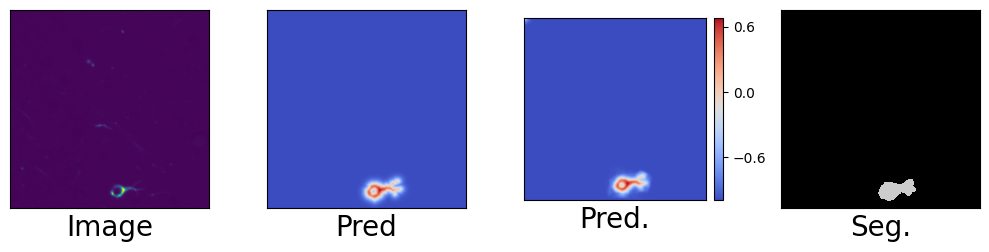

In [160]:
print (nft_pred_seg[0].shape)

index = random.choice (range(0, len (nft_pred_seg)))

image = nft_image_crops [index]
sdt = nft_sdt[index]
pred_sdt = nft_pred_sdt[index]
pred_seg = nft_pred_seg[index]
plot_four (image, sdt, pred_sdt, pred_seg, label = "Pred")

In [107]:
pb_pred_sdt = []
pb_pred_seg = []
counter = 0
for image in pb_image_crops:
    image = torch.tensor (image, dtype = torch.float32)
    image = torch.unsqueeze (image, dim = 0)
    image = torch.unsqueeze (image, dim = 0)
    # print (image.shape)
    image = image.to (device)
    with torch.no_grad():
        pred_sdt = model (image)
    # print (pred_sdt.shape)
    
    pred_sdt = np.squeeze(pred_sdt.cpu().detach().numpy())
    threshold = threshold_otsu(pred_sdt)
    semantic_segmentation = pred_sdt > threshold
    pred_seg = watershed_from_boundary_distance(pred_sdt, semantic_segmentation, min_seed_distance=40)
    pb_pred_sdt.append (pred_sdt)
    pb_pred_seg.append (pred_seg)

(256, 256)


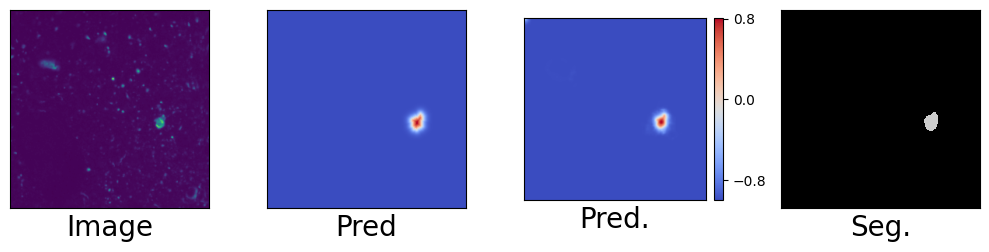

In [229]:
print (pb_pred_seg[0].shape)

index = random.choice (range(0, len (pb_pred_seg)))

image = pb_image_crops [index]
sdt = pb_sdt[index]
pred_sdt = pb_pred_sdt[index]
pred_seg = pb_pred_seg[index]
plot_four (image, sdt, pred_sdt, pred_seg, label = "Pred")

In [184]:
def clear_and_pad(mask, raw_image):
    cleared_border = clear_border(mask)
    padded_mask = np.pad(cleared_border, pad_width=64, mode='constant', constant_values=0)
    padded_raw = np.pad(raw_image, pad_width=((64, 64), (64, 64)), mode='symmetric')
    return padded_mask, padded_raw

In [183]:
print (nft_image_crops[0].shape)
print (nft_pred_seg[0].shape)
print(type(clear_and_pad))
# a = clear_and_pad (nft_pred_seg[0], nft_image_crops[0])

(256, 256)
(256, 256)
<class 'tuple'>


Region properties <skimage.measure._regionprops.RegionProperties object at 0x71ae62b7e6d0>
Centroid for label 19: (np.float64(215.16363636363636), np.float64(284.92727272727274))


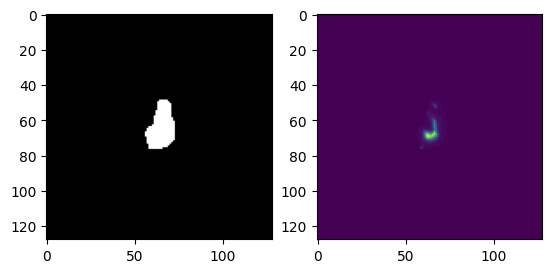

In [236]:
a = clear_and_pad (nft_pred_seg[0], nft_image_crops[0])
b = crop_and_extract_single_nuclei(a[0], a[1])
type ( (b[3][0]))
crop = b[2][0]
raw = b[3][0]

fig, ax = plt.subplots(1,2)
ax[0].imshow(crop, cmap = "grey")
ax[1].imshow(raw)


In [161]:
def crop_and_extract_single_nuclei(padded_mask, padded_raw):
    list_of_cropped_raw_per_image = []
    list_of_cropped_mask_per_image = []
    list_of_cropped_mask_maskout_per_image = []
    list_of_cropped_raw_maskout_per_image = []

    for i,props in enumerate(regionprops(padded_mask)):
        print(f"Region properties {props}")
        centroid = props.centroid
        print(f"Centroid for label {props.label}: {centroid}")
        if np.isnan(centroid[0]):
            print(f"Centroid is NaN for label {props.label}, skipping.")
            continue
        crop_box = [int(centroid[0])-64, int(centroid[0])+64, int(centroid[1])-64, int(centroid[1])+64]
        raw_crop = padded_raw[crop_box[0]:crop_box[1], crop_box[2]:crop_box[3]]
        mask_crop = padded_mask[crop_box[0]:crop_box[1], crop_box[2]:crop_box[3]]
        mask_bool = mask_crop == props.label
        raw_maskout=raw_crop.copy()
        raw_maskout[ ~mask_bool] = 0
        mask_maskout= mask_crop.copy()
        mask_maskout[~mask_bool] = 0
        cropped_raw_np=raw_crop
        cropped_raw_maskout_np= raw_maskout
        cropped_mask_np = mask_crop
        cropped_mask_maskout_np = mask_maskout
        list_of_cropped_raw_per_image.append(cropped_raw_np)
        list_of_cropped_mask_per_image.append(cropped_mask_np)
        list_of_cropped_mask_maskout_per_image.append(cropped_mask_maskout_np)
        list_of_cropped_raw_maskout_per_image.append(cropped_raw_maskout_np)
    return list_of_cropped_mask_per_image, list_of_cropped_raw_per_image, list_of_cropped_mask_maskout_per_image, list_of_cropped_raw_maskout_per_image

In [241]:
cropped_nfts = []
len (nft_image_crops) == len (nft_pred_seg)

for i in range (len(nft_image_crops)):
    image = nft_image_crops[i]
    mask = nft_pred_seg[i]
    cap = clear_and_pad (mask, image)
    nft = crop_and_extract_single_nuclei (cap[0], cap[1])
    nft = nft[3]
    for j in range (len(nft)):
        cropped_nfts.append (nft[j])


Region properties <skimage.measure._regionprops.RegionProperties object at 0x71ae62b73290>
Centroid for label 19: (np.float64(215.16363636363636), np.float64(284.92727272727274))
Region properties <skimage.measure._regionprops.RegionProperties object at 0x71ae62964490>
Centroid for label 27: (np.float64(300.67880085653104), np.float64(171.11777301927194))
Region properties <skimage.measure._regionprops.RegionProperties object at 0x71ae630fa610>
Centroid for label 4: (np.float64(81.69607843137256), np.float64(237.61764705882354))
Region properties <skimage.measure._regionprops.RegionProperties object at 0x71ae630f9250>
Centroid for label 16: (np.float64(229.1958762886598), np.float64(250.11855670103094))
Region properties <skimage.measure._regionprops.RegionProperties object at 0x71ae630bd550>
Centroid for label 10: (np.float64(151.14238410596028), np.float64(189.29470198675497))
Region properties <skimage.measure._regionprops.RegionProperties object at 0x71ae630f9110>
Centroid for labe

<class 'numpy.ndarray'>


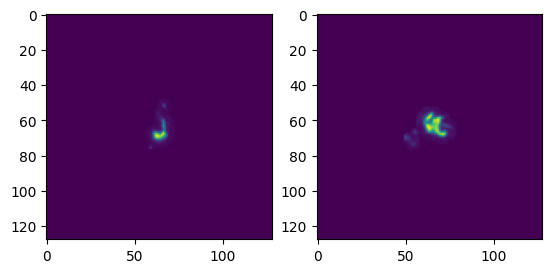

In [242]:
print (type (cropped_nfts[0]))

raw_1 = cropped_nfts[0]
raw_2 = cropped_nfts[1]

fig, ax = plt.subplots(1,2)
ax[0].imshow(raw_1)
ax[1].imshow(raw_2)

In [243]:
cropped_pbs = []
len (pb_image_crops) == len (pb_pred_seg)

for i in range (len(pb_image_crops)):
    image = pb_image_crops[i]
    mask = pb_pred_seg[i]
    cap = clear_and_pad (mask, image)
    pb = crop_and_extract_single_nuclei (cap[0], cap[1])
    pb = pb[3]
    for j in range (len(pb)):
        cropped_pbs.append (pb[j])

Region properties <skimage.measure._regionprops.RegionProperties object at 0x71ae62b6d1d0>
Centroid for label 26: (np.float64(291.37016574585635), np.float64(248.88121546961327))
Region properties <skimage.measure._regionprops.RegionProperties object at 0x71ae62b89b50>
Centroid for label 27: (np.float64(291.2624584717608), np.float64(290.01993355481727))
Region properties <skimage.measure._regionprops.RegionProperties object at 0x71ae6329c710>
Centroid for label 15: (np.float64(149.04329004329006), np.float64(138.7922077922078))
Region properties <skimage.measure._regionprops.RegionProperties object at 0x71ae6311c890>
Centroid for label 28: (np.float64(265.4810126582278), np.float64(186.93248945147678))
Region properties <skimage.measure._regionprops.RegionProperties object at 0x71ae63018f10>
Centroid for label 28: (np.float64(242.31313131313132), np.float64(159.4949494949495))
Region properties <skimage.measure._regionprops.RegionProperties object at 0x71ae6301a550>
Centroid for label

1621


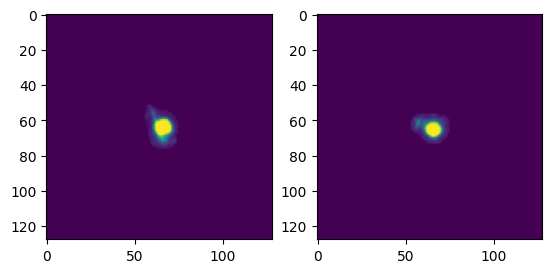

In [244]:
print (len (cropped_pbs))

raw_1 = cropped_pbs[0]
raw_2 = cropped_pbs[1]

fig, ax = plt.subplots(1,2)
ax[0].imshow(raw_1)
ax[1].imshow(raw_2)

In [245]:
#Initiating zarr
zarr_path = "/mnt/efs/aimbl_2025/student_data/S-DM/Data/zarr_storage/"
test_zarr = zarr_path +"nft_pb_classification.zarr"

In [250]:
root = zarr.open(test_zarr, mode='w')
classes = ["tangles", "Pick bodies"]

for cl in classes:
    root.create_group(cl)

# for i in range (len (cropped_nfts)):
#     root ["tangles"].create_array (name = str (i), data = cropped_nfts[i])




In [251]:
for i in range (len (cropped_nfts)):
    root ["tangles"].create_array (name = str (i), data = cropped_nfts[i])

for j in range (len (cropped_pbs)):
    root ["Pick bodies"].create_array (name = str (j), data = cropped_pbs[j])

In [ ]:
root["tangles"][]

2381

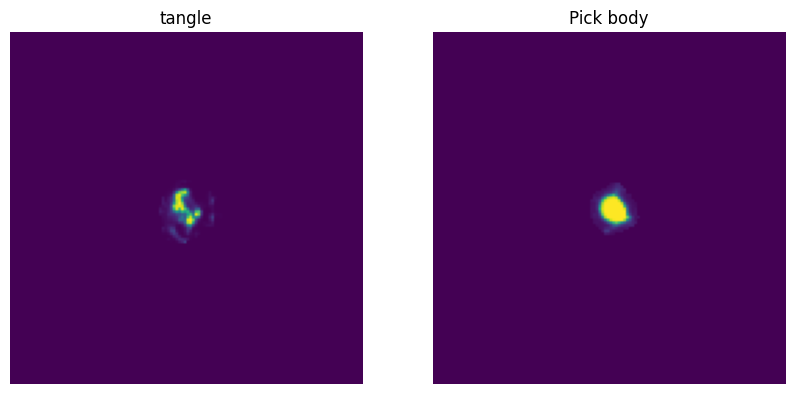

In [276]:
tangle_index = random.choice (range (len(root["tangles"])))
pick_index = random.choice (range (len(root["Pick bodies"])))

x = root["tangles"][str (tangle_index)]
y = root ["Pick bodies"][str (pick_index)]

    
    
    
    # Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(x)
axes[0].set_title("tangle")
axes[0].axis("off")
    
axes[1].imshow(y)
axes[1].set_title("Pick body")
axes[1].axis("off")
    
plt.show()